In [4]:
import torch
import numpy as np
import pandas as pd

In [2]:
import torch_geometric

`num_timesteps_in` and `num_timesteps_out` -> how many previous time data points(sequence) we use to and how many we predict into the future. so if every t is 5 minutes apart , and its 12 and 12, you'd say use the previous 12x5 60 mins to predict the next 60

In [6]:
from torch_geometric_temporal.dataset import METRLADatasetLoader 
from torch_geometric_temporal.signal import StaticGraphTemporalSignal # data object , https://pytorch-geometric-temporal.readthedocs.io/en/latest/notes/introduction.html#data-structures

loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

print("Dataset type:  ", dataset)

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x0000021D93ECE5B0>


#### Dataset Explanation

- From https://arxiv.org/abs/1707.01926 this paper and documentation 
- Data on roads and sensors which monitor traffic speed
- 207 sensors on highwayas 
- 34249 samples/sequences

#### Data Sample
- 207 nodes
- 2 features per node (speed, time)
- 12 timesteps per bucket (12 x 5 min = 60 min) 
- Labels for 12 future timesteps (normalized speed) --> node regression
- Edge_attr is build based on the distances between sensors + threshold
- Further details: https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/dataset/metr_la.html#METRLADatasetLoader
- Raw data: https://graphmining.ai/temporal_datasets/METR-LA.zip

Data/Measurements collected from 207 sensors. Measurements take place every 5 minutes. 

In [12]:
next(iter(dataset)) # loads in batches , this is A SINGLE DATA POINT.

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

We have for each "bucket" : 207 nodes, each with 2 features, and 12 graphs(measurements/samples whatever) which are taken every 5 mins

 on y = [207,12] it means 207 nodes, and you have 12 labels, which are 12 TIMESTEPS INTO THE FUTURE (the ones we want to predict) These labels are pretty much normalized speed so its a under node regression pretty much.
 
 So we use a sequence of 12 samples to predict 12 timesteps into the future.
 
 
 
In this dataset, speed is features for the sequence we use to predict, and labels for the future ones.
https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/dataset/metr_la.html#METRLADatasetLoader 

To understand how its consturcted..


In any case some datasets are made are built different , using lags which is like an offset of setting how far into the future you want to check ,or are just not single shot(1 mbedding output)

#### Visualize target variable (labels/normalized speeds

<AxesSubplot:>

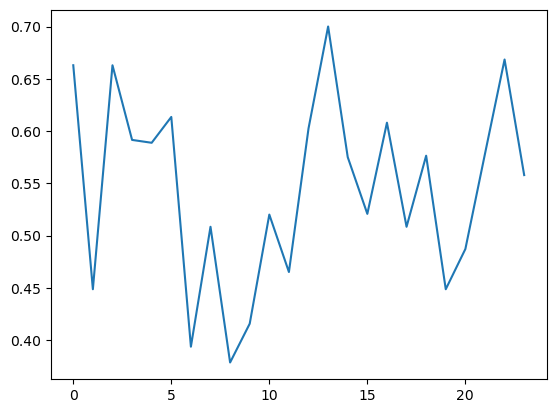

In [13]:
import seaborn as sns
# Visualize traffic over time
sensor_number = 1
hours = 24 # subset of DATA samples 
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
sns.lineplot(data=sensor_labels)

In [55]:
sensor_labels # as we see  above, we picked ONLY ONE FROM EVERY 1 HOUR SAMPLE, THE FIRST ONE.

[0.6630589365959167,
 0.44864222407341003,
 0.6630589365959167,
 0.5915867686271667,
 0.588837742805481,
 0.6135781407356262,
 0.39366358518600464,
 0.5084314346313477,
 0.3785443902015686,
 0.4156549870967865,
 0.5201146006584167,
 0.465135782957077,
 0.6025824546813965,
 0.700169563293457,
 0.5750930309295654,
 0.5208016633987427,
 0.6080800890922546,
 0.5084314346313477,
 0.5764675736427307,
 0.44864222407341003,
 0.4871271550655365,
 0.5782346725463867,
 0.6685569882392883,
 0.5579122304916382]

I select a subset of the samples -> in this case the first 24 ones.(first 24 data points)

That means, that since every point is 1 hour (and in that 12 measurements of 5 minute intervals) we get 24 horus.

the y axis is standardized speeds( you cant make sense of them , need to look at raw data) but we can see that thorough the day, in the morning speeds are low and then around 11-14 it spikes high.

In [21]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

# they are split in some way correctly

In [31]:
train_dataset[0] # 1 data point of 12 graphs/measurements

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

In [30]:
next(iter(train_dataset))

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

#### Model creation & Training

In [32]:
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN # uses GCN + GRU (attention) (attention temporal graph convolution)
# several GCN layers are combibined with the GRU unit

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features,  # easy to create this block(its not just 1 laayer)
                           out_channels=32, 
                           periods=periods) # periods specifies how many periods you have/want to predict in future
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods) # prediction for the next 12 timesteps

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # create this embedding in order to calculate the 12 next labels
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

If you want to add more layers ( e.g. more GCN layers in the A3TGCN block ) the only way is through the source code and making it yourself...


Output of TGCN is ONE Embedding which holds spatial&temporal information.

When you have 1 output embedding and predict all labels at once with it its called SINGLE SHOT MODEL. (the other is autoregressive, use every hidden state after every TGNN block)

the A3TGCN is foundamentally a single shot.

In [33]:
device = torch.device('cpu') # cuda
subset = 2000

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device) # 2 node features ,12 periods
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # adam as always
model.train()

print("Running training...")
for epoch in range(10): 
    loss = 0
    step = 0
    for snapshot in train_dataset:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index) # take nodes, take edges of the snapshot and predict
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2)  # use MSE to compare
        step += 1
        if step > subset: # stop cuz memory
            break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

Running training...
Epoch 0 train MSE: 0.7589
Epoch 1 train MSE: 0.7435
Epoch 2 train MSE: 0.7299
Epoch 3 train MSE: 0.7143
Epoch 4 train MSE: 0.6957
Epoch 5 train MSE: 0.6748
Epoch 6 train MSE: 0.6531
Epoch 7 train MSE: 0.6328
Epoch 8 train MSE: 0.6146
Epoch 9 train MSE: 0.5980


This took a good 2.5 hours to train.

#### Test & Visualization of result.

In [34]:
model.eval()
loss = 0
step = 0
horizon = 288

# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

Test MSE: 0.6939


Horizon 288 : 288/12 = 24 . every sample/block/whatever has 12 measurements.. so were looking forward 1 day..


The model gets 1 hour and predicts the next hour

In [35]:

sensor = 123 # pick a specific sensor you want to viz
timestep = 11  # pick a specific label you want to viz (has 5 minutes inside)


preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (289,)


<AxesSubplot:>

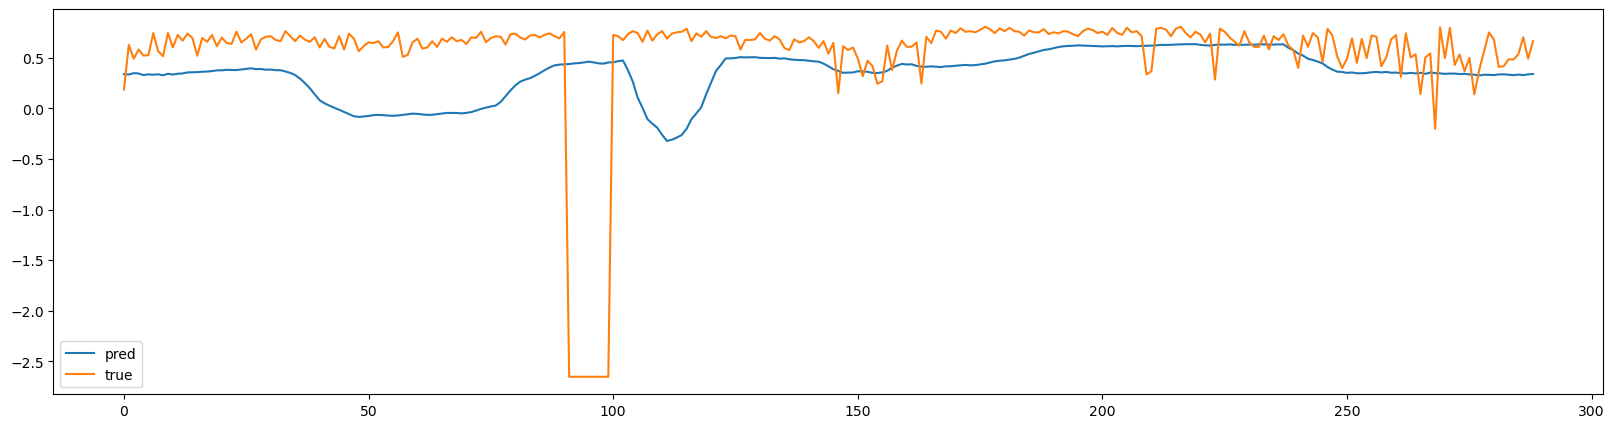

In [36]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

- The further away the point in time is, the worse the predictions get
- Predictions shape: [num_data_points, num_sensors, num_timesteps]

In [39]:
labs[0]

0.18474454

In [46]:
labels

[tensor([[0.5765, 0.6445, 0.4926,  ..., 0.4280, 0.4541, 0.3332],
         [0.3352, 0.2301, 0.5036,  ..., 0.0507, 0.5861, 0.1683],
         [0.4218, 0.5270, 0.6905,  ..., 0.7125, 0.5366, 0.7455],
         ...,
         [0.4899, 0.3847, 0.4816,  ..., 0.5765, 0.5146, 0.5201],
         [0.6754, 0.4157, 0.5586,  ..., 0.5332, 0.6301, 0.5586],
         [0.4095, 0.5332, 0.5201,  ..., 0.5084, 0.5641, 0.5091]]),
 tensor([[0.6445, 0.4926, 0.4466,  ..., 0.4541, 0.3332, 0.6198],
         [0.2301, 0.5036, 0.1559,  ..., 0.5861, 0.1683, 0.2858],
         [0.5270, 0.6905, 0.5579,  ..., 0.5366, 0.7455, 0.7311],
         ...,
         [0.3847, 0.4816, 0.6321,  ..., 0.5146, 0.5201, 0.5579],
         [0.4157, 0.5586, 0.2054,  ..., 0.6301, 0.5586, 0.5579],
         [0.5332, 0.5201, 0.5270,  ..., 0.5641, 0.5091, 0.5827]]),
 tensor([[0.4926, 0.4466, 0.6074,  ..., 0.3332, 0.6198, 0.6321],
         [0.5036, 0.1559, 0.2858,  ..., 0.1683, 0.2858, 0.5703],
         [0.6905, 0.5579, 0.7311,  ..., 0.7455, 0.7311, 0.

In [47]:
labels[0]

tensor([[0.5765, 0.6445, 0.4926,  ..., 0.4280, 0.4541, 0.3332],
        [0.3352, 0.2301, 0.5036,  ..., 0.0507, 0.5861, 0.1683],
        [0.4218, 0.5270, 0.6905,  ..., 0.7125, 0.5366, 0.7455],
        ...,
        [0.4899, 0.3847, 0.4816,  ..., 0.5765, 0.5146, 0.5201],
        [0.6754, 0.4157, 0.5586,  ..., 0.5332, 0.6301, 0.5586],
        [0.4095, 0.5332, 0.5201,  ..., 0.5084, 0.5641, 0.5091]])

In [54]:
labels[0][sensor] # random 123 sensor, 12 labels for that 1 hour interval

tensor([0.6507, 0.6445, 0.4486, 0.5394, 0.4528, 0.5256, 0.3352, 0.3229, 0.3057,
        0.1621, 0.6905, 0.1847])

In [50]:
labels[0][sensor][11] # a specific 5 minute interval label

tensor(0.1847)

Explore in the future (TGN specifically)
- https://towardsdatascience.com/temporal-graph-networks-ab8f327f2efe

- https://memgraph.com/blog/amazon-user-item-recommender-with-tgn-and-memgraph
- implement TGN gnn
- https://github.com/twitter-research/tgn
- https://theaisummer.com/gnn-architectures/
- Sergios karagiannakos, Giorgos Bouritsas, Prof. Stefanos Zafeiriou
- https://theaisummer.com/graph-convolutional-networks/